In [46]:


import pandas as pd
import os

# Get all files from the /merged directory training data 
merged_dir = 'traindata'
all_files = []

# Walk through the directory to find all files
for root, dirs, files in os.walk(merged_dir):
    for file in files:
        if file.endswith(('.csv', '.parquet', '.json', '.xlsx')):  # Add other file types as needed
            all_files.append(os.path.join(root, file))

# Load and concatenate all files into a single dataframe
dfs = []
for file_path in all_files:
    try:
        if file_path.endswith('.csv'):
            temp_df = pd.read_csv(file_path)
            if len(dfs) >= 10:  # Only load first 15 files
                break
       
        
        dfs.append(temp_df)
        print(f"Loaded: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Concatenate all dataframes
if dfs:
    train = pd.concat(dfs, ignore_index=True)
    print(f"Successfully loaded {len(dfs)} files into dataframe")
else:
    print("No files found or loaded")

Loaded: traindata/merged_2013-11-19.csv
Loaded: traindata/merged_2013-12-06.csv
Loaded: traindata/merged_2013-11-18.csv
Loaded: traindata/merged_2013-11-22.csv
Loaded: traindata/merged_2013-12-02.csv
Loaded: traindata/merged_2013-11-10.csv
Loaded: traindata/merged_2013-11-03.csv
Loaded: traindata/merged_2013-11-21.csv
Loaded: traindata/merged_2013-11-07.csv
Loaded: traindata/merged_2013-12-13.csv
Successfully loaded 10 files into dataframe


In [47]:
print(train.head)

<bound method NDFrame.head of          Milan_Grid_Square_ID      Time Interval (GMT+1)  \
0                        2526  2013-11-19 00:00:00+01:00   
1                        2526  2013-11-19 00:10:00+01:00   
2                        2526  2013-11-19 00:20:00+01:00   
3                        2526  2013-11-19 00:30:00+01:00   
4                        2526  2013-11-19 00:40:00+01:00   
...                       ...                        ...   
3230608                  7475  2013-12-13 22:20:00+01:00   
3230609                  7475  2013-12-13 22:30:00+01:00   
3230610                  7475  2013-12-13 22:40:00+01:00   
3230611                  7475  2013-12-13 23:40:00+01:00   
3230612                  7475  2013-12-13 23:50:00+01:00   

         Internet traffic activity  SMS activity  Call activity  is_day_off  \
0                         7.569519      0.192982       0.129232           0   
1                         7.468271      1.109266       0.345474           0   
2           

In [48]:

# Convert Time Interval column to datetime first
train['Time Interval (GMT+1)'] = pd.to_datetime(train['Time Interval (GMT+1)'])

# Split the Time Interval column into separate date and time components
train['Date'] = train['Time Interval (GMT+1)'].dt.date
train['Time_Numeric'] = train['Time Interval (GMT+1)'].dt.hour + train['Time Interval (GMT+1)'].dt.minute/60

print("Time interval split completed!")
print(f"Date column sample: {train['Date'].head()}")
print(f"Time_Numeric column sample: {train['Time_Numeric'].head()}")
print(f"Data types - Date: {train['Date'].dtype}, Time_Numeric: {train['Time_Numeric'].dtype}")

Time interval split completed!
Date column sample: 0    2013-11-19
1    2013-11-19
2    2013-11-19
3    2013-11-19
4    2013-11-19
Name: Date, dtype: object
Time_Numeric column sample: 0    0.000000
1    0.166667
2    0.333333
3    0.500000
4    0.666667
Name: Time_Numeric, dtype: float64
Data types - Date: object, Time_Numeric: float64


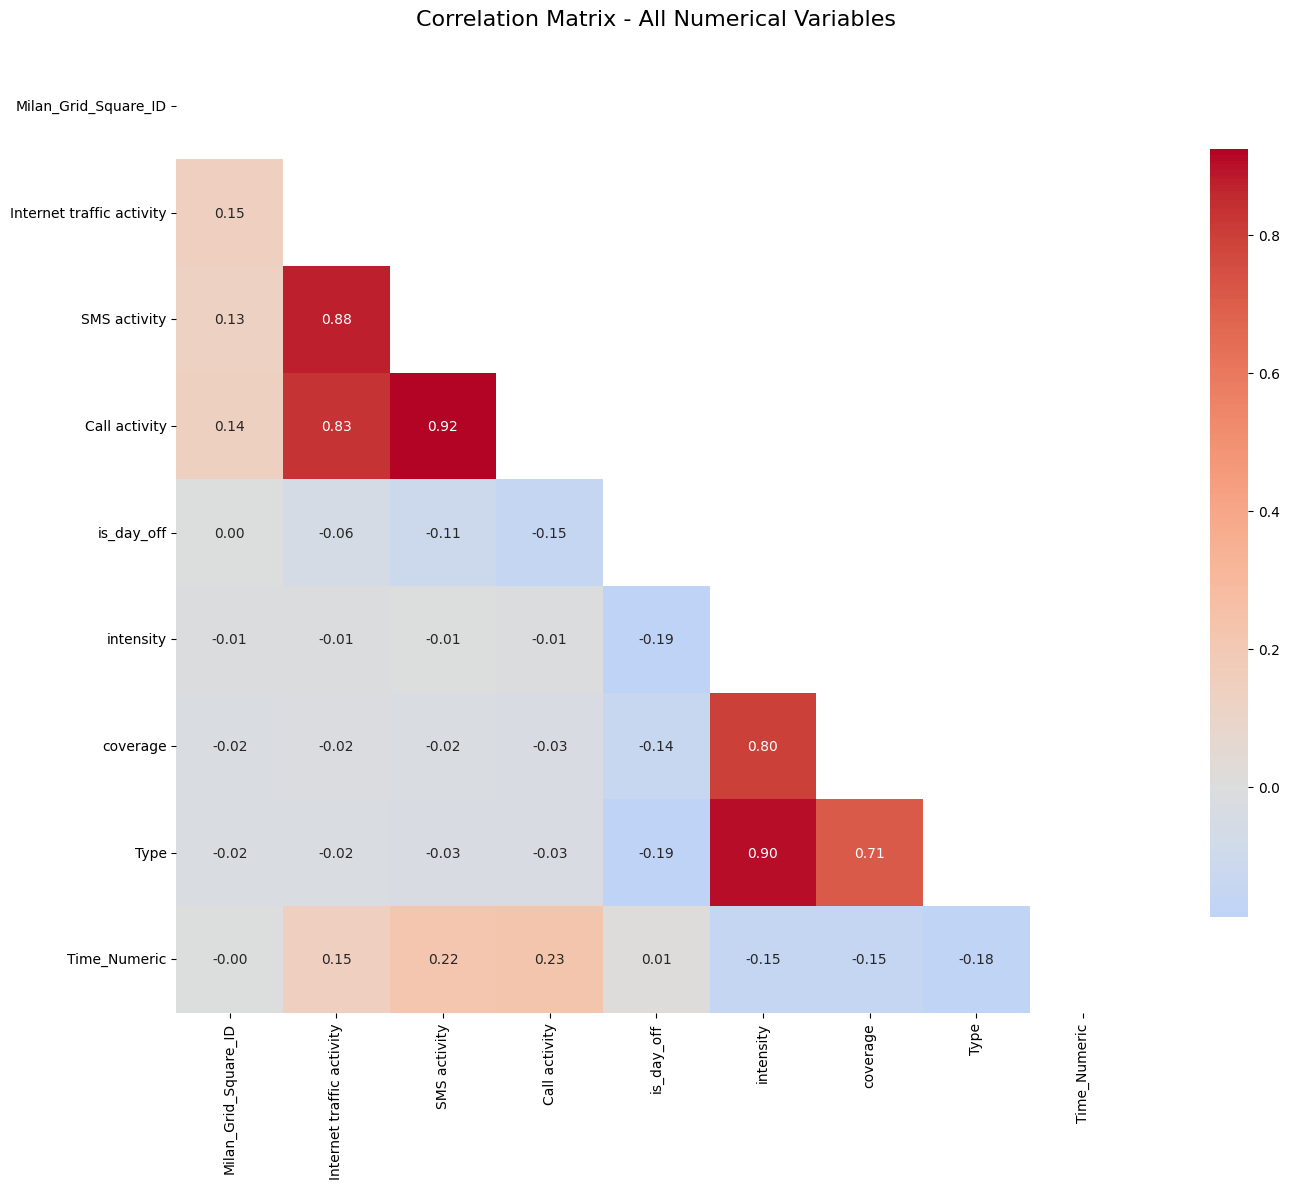

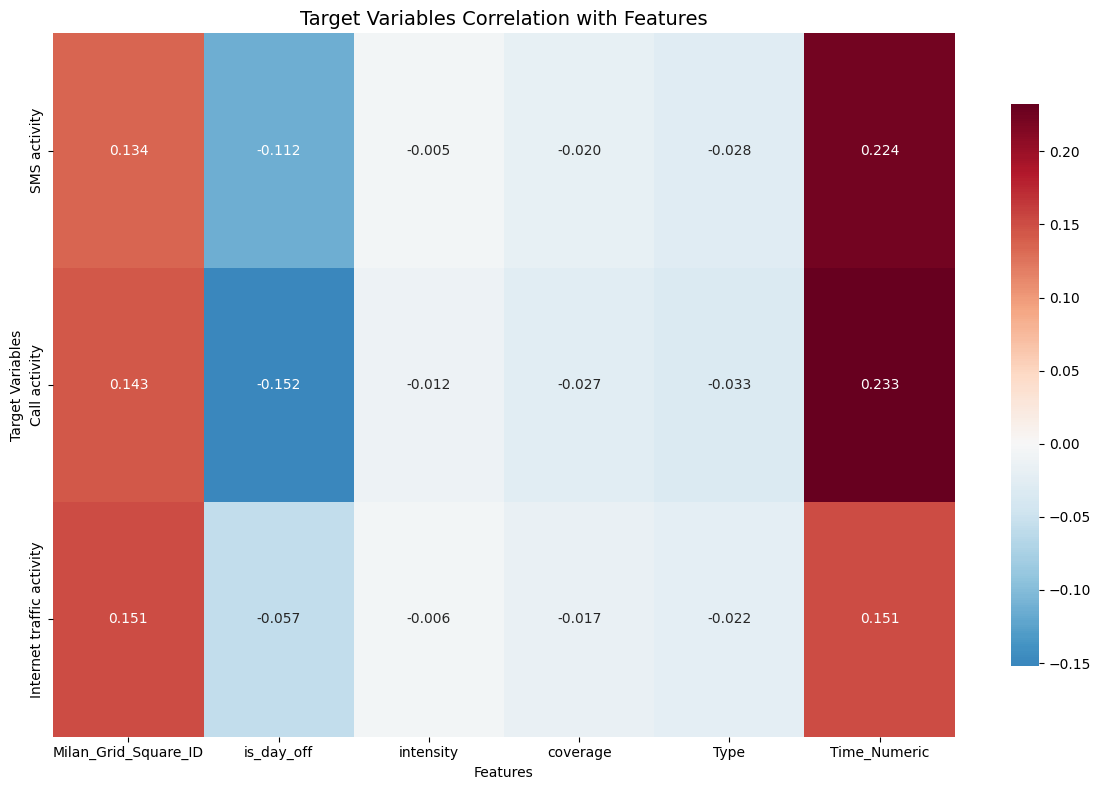

Correlation matrix created successfully!
Matrix shape: (9, 9)


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns that exist in the dataframe
numerical_cols = train.select_dtypes(include=[np.number]).columns.tolist()

# Create correlation matrix for all numerical variables
correlation_matrix = train[numerical_cols].corr()
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - All Numerical Variables', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Define target variables
target_vars = ['SMS activity', 'Call activity', 'Internet traffic activity']

# Focus on target variables correlation with other features
target_correlation = correlation_matrix[target_vars].drop(target_vars, axis=0)
plt.figure(figsize=(12, 8))
sns.heatmap(target_correlation.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.3f',
            cbar_kws={"shrink": .8})
plt.title('Target Variables Correlation with Features', fontsize=14)
plt.ylabel('Target Variables')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

print("Correlation matrix created successfully!")
print(f"Matrix shape: {correlation_matrix.shape}")


1. Creating temporal features...
2. Engineering Grid Square features...
3. Transforming target variables...
SMS activity skewness: 4.760
Call activity skewness: 4.206
Internet traffic activity skewness: 3.927
4. Creating interaction features...
5. Preparing final feature set...
Final feature set: 20 features
Features: ['Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off', 'hour_sin', 'hour_cos', 'grid_density', 'grid_x', 'grid_y', 'time_dayoff_interaction', 'grid_time_interaction', 'day_sin', 'day_cos', 'is_weekend', 'time_Night', 'time_Morning', 'time_Afternoon', 'time_Evening', 'grid_avg_sms', 'grid_avg_call', 'grid_avg_internet']


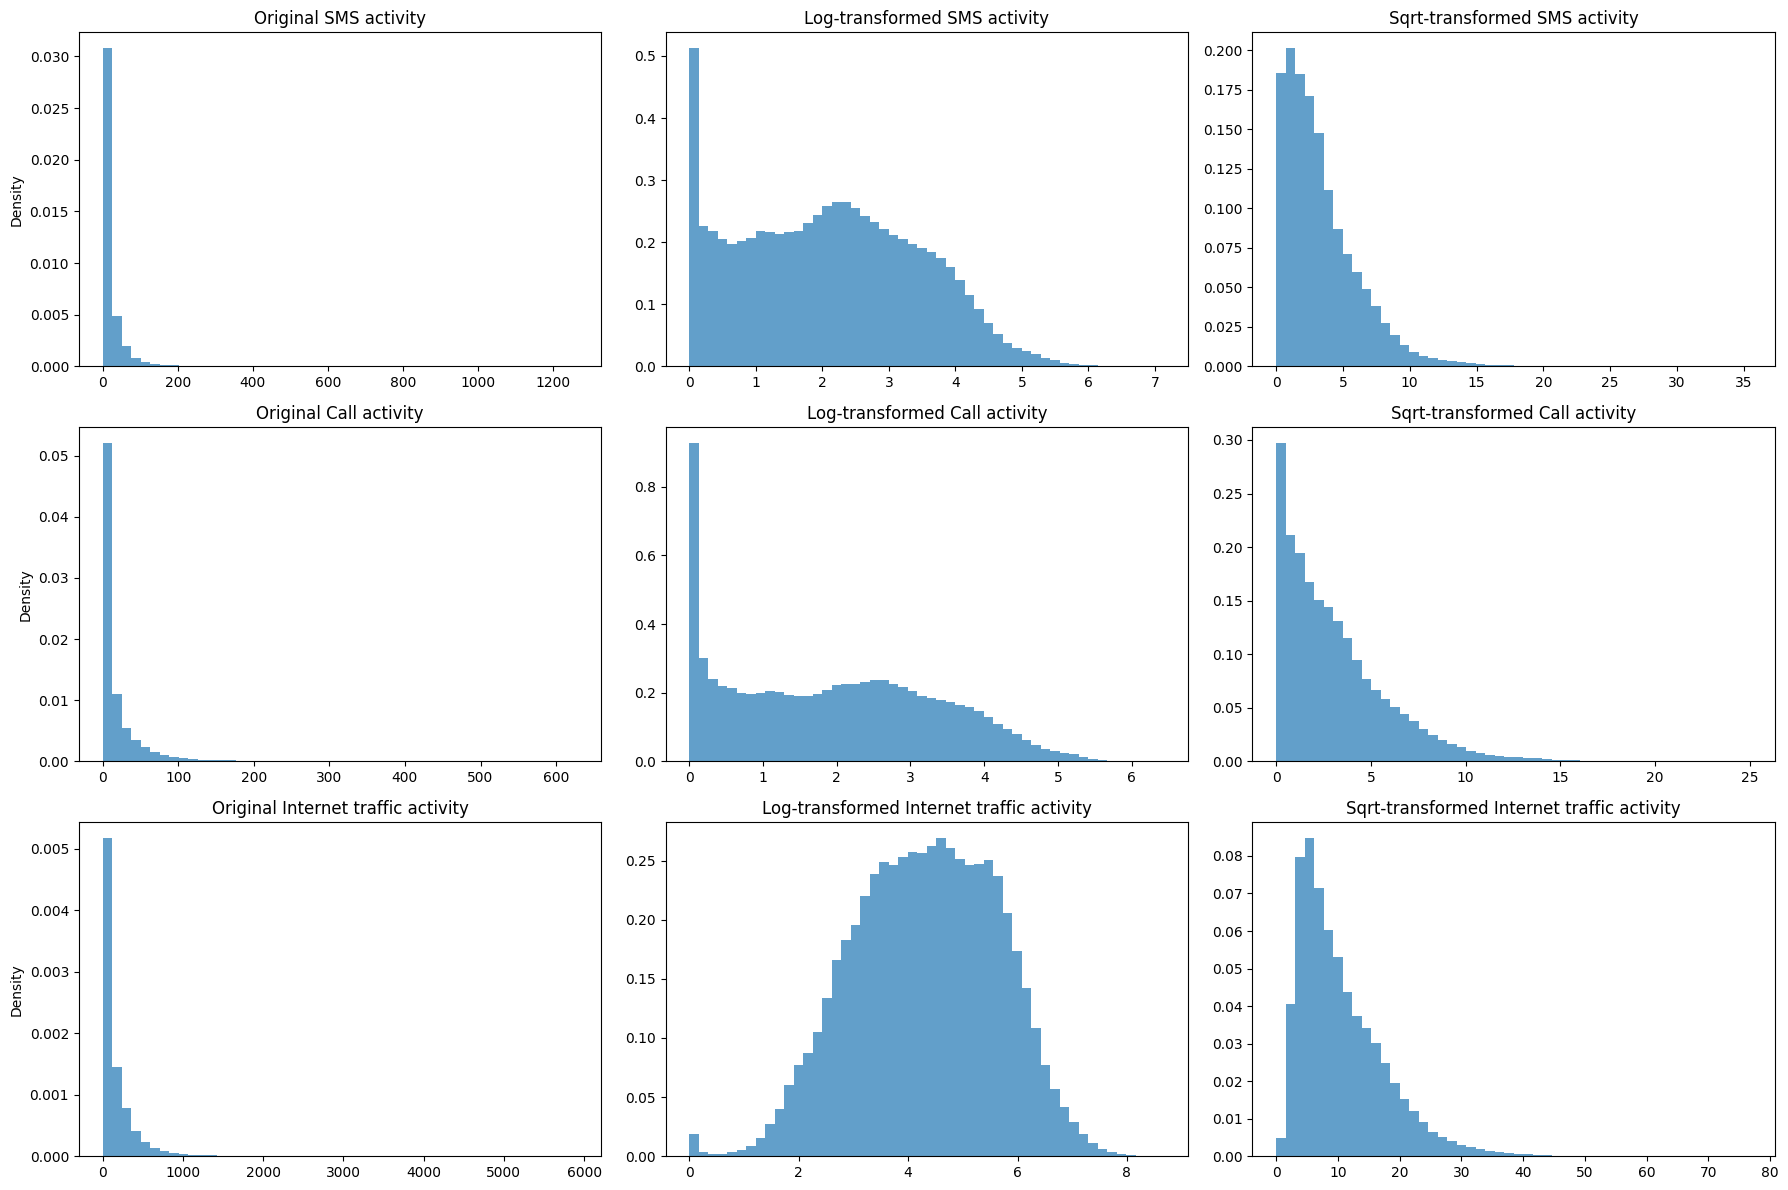

In [52]:

# Comprehensive Data Transformation Pipeline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns

def comprehensive_data_transformation(df):
    """
    Apply comprehensive transformations to improve model performance
    """
    data = df.copy()
    
    # 1. TEMPORAL FEATURE ENGINEERING
    print("1. Creating temporal features...")
    
    # Convert time to cyclical features (important for time patterns)
    data['hour_sin'] = np.sin(2 * np.pi * data['Time_Numeric'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['Time_Numeric'] / 24)
    
    # Create time-based bins
    data['time_period'] = pd.cut(data['Time_Numeric'], 
                               bins=[0, 6, 12, 18, 24], 
                               labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    # Day of week features (if date available)
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data['day_of_week'] = data['Date'].dt.dayofweek
        data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
        data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
        data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    
    # 2. GRID SQUARE FEATURE ENGINEERING
    print("2. Engineering Grid Square features...")
    
    # Instead of one-hot encoding, create meaningful features from Grid ID
    # Grid density features
    grid_counts = data['Milan_Grid_Square_ID'].value_counts()
    data['grid_density'] = data['Milan_Grid_Square_ID'].map(grid_counts)
    
    # Grid-based aggregated features (mean activity by grid)
    for target in ['SMS activity', 'Call activity', 'Internet traffic activity']:
        grid_mean = data.groupby('Milan_Grid_Square_ID')[target].mean()
        data[f'grid_avg_{target.split()[0].lower()}'] = data['Milan_Grid_Square_ID'].map(grid_mean)
    
    # Grid coordinates (if grid follows spatial pattern)
    # Assuming grid IDs have spatial meaning - extract coordinates
    data['grid_x'] = data['Milan_Grid_Square_ID'] % 100  # Extract x coordinate
    data['grid_y'] = data['Milan_Grid_Square_ID'] // 100  # Extract y coordinate
    
    # 3. TARGET VARIABLE TRANSFORMATIONS
    print("3. Transforming target variables...")
    
    target_vars = ['SMS activity', 'Call activity', 'Internet traffic activity']
    transformed_targets = {}
    
    for target in target_vars:
        # Check distribution and apply appropriate transformation
        skewness = data[target].skew()
        print(f"{target} skewness: {skewness:.3f}")
        
        if abs(skewness) > 1:  # Highly skewed
            # Try log transformation (add 1 to handle zeros)
            data[f'{target}_log'] = np.log1p(data[target])
            
            # Try Box-Cox transformation
            pt = PowerTransformer(method='box-cox', standardize=False)
            # Box-Cox requires positive values
            if data[target].min() > 0:
                data[f'{target}_boxcox'] = pt.fit_transform(data[[target]]).flatten()
            
            # Try sqrt transformation
            data[f'{target}_sqrt'] = np.sqrt(data[target])
            
            transformed_targets[target] = f'{target}_log'  # Use log as default
        else:
            transformed_targets[target] = target  # No transformation needed
    
    # 4. INTERACTION FEATURES
    print("4. Creating interaction features...")
    
    # Time-based interactions
    data['time_dayoff_interaction'] = data['Time_Numeric'] * data['is_day_off']
    data['grid_time_interaction'] = data['grid_density'] * data['Time_Numeric']
    
    # Activity correlations (targets are highly correlated)
    data['sms_call_ratio'] = data['SMS activity'] / (data['Call activity'] + 1)
    data['internet_total_ratio'] = data['Internet traffic activity'] / (
        data['SMS activity'] + data['Call activity'] + data['Internet traffic activity'] + 1)
    
    # 5. FEATURE SCALING AND SELECTION
    print("5. Preparing final feature set...")
    
    # Select features for modeling
    feature_cols = [
        # Original features
        'Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off',
        
        # Temporal features
        'hour_sin', 'hour_cos',
        
        # Grid features
        'grid_density', 'grid_x', 'grid_y',
        
        # Interaction features
        'time_dayoff_interaction', 'grid_time_interaction',
        
    ]
    
    # Add day features if available
    if 'day_sin' in data.columns:
        feature_cols.extend(['day_sin', 'day_cos', 'is_weekend'])
    
    # Add time period dummies
    if 'time_period' in data.columns:
        time_dummies = pd.get_dummies(data['time_period'], prefix='time')
        data = pd.concat([data, time_dummies], axis=1)
        feature_cols.extend(time_dummies.columns)
    
    # Add grid average features
    grid_avg_cols = [col for col in data.columns if col.startswith('grid_avg_')]
    feature_cols.extend(grid_avg_cols)
    
    # Remove any columns that don't exist
    feature_cols = [col for col in feature_cols if col in data.columns]
    
    print(f"Final feature set: {len(feature_cols)} features")
    print(f"Features: {feature_cols}")
    
    return data, feature_cols, transformed_targets

# Apply transformations
transformed_data, final_features, target_transformations = comprehensive_data_transformation(train)

# Visualize transformation effects
def plot_transformation_effects(original_data, transformed_data, target_vars):
    """Plot before/after distributions"""
    
    fig, axes = plt.subplots(len(target_vars), 3, figsize=(18, 12))
    
    for i, target in enumerate(target_vars):
        # Original distribution
        axes[i, 0].hist(original_data[target], bins=50, alpha=0.7, density=True)
        axes[i, 0].set_title(f'Original {target}')
        axes[i, 0].set_ylabel('Density')
        
        # Log transformed
        if f'{target}_log' in transformed_data.columns:
            axes[i, 1].hist(transformed_data[f'{target}_log'], bins=50, alpha=0.7, density=True)
            axes[i, 1].set_title(f'Log-transformed {target}')
        
        # Box-Cox transformed (if available)
        if f'{target}_boxcox' in transformed_data.columns:
            axes[i, 2].hist(transformed_data[f'{target}_boxcox'], bins=50, alpha=0.7, density=True)
            axes[i, 2].set_title(f'Box-Cox {target}')
        else:
            axes[i, 2].hist(transformed_data[f'{target}_sqrt'], bins=50, alpha=0.7, density=True)
            axes[i, 2].set_title(f'Sqrt-transformed {target}')
    
    plt.tight_layout()
    plt.show()

# Visualize transformations
plot_transformation_effects(train, transformed_data, target_vars)


In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
# Import the required metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
import pandas as pd # Import pandas to handle dataframes easily

X = transformed_data[final_features]

# The 'target_transformations' dictionary tells you which target columns to use

y = transformed_data[list(target_transformations.values())]

# 1. SPLIT AND SCALE THE DATA (no changes here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. DEFINE THE CORRECT MODEL: XGBRegressor
# We want to predict a continuous value, so we use XGBRegressor.
# The base regressor model is defined here.
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Wrap the regressor in MultiOutputRegressor to handle multiple target variables
multi_output_model = MultiOutputRegressor(estimator=xgb_reg)

# 2. DEFINE THE MODEL AND WRAPPER
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
multi_output_model = MultiOutputRegressor(estimator=xgb_reg)

# 3. DEFINE THE HYPERPARAMETER GRID
# The 'estimator__' prefix is crucial for passing params to the wrapped XGBRegressor.
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [3, 5, 7],
    'estimator__learning_rate': [0.01, 0.1],
    'estimator__subsample': [0.8, 1.0]
}

# 4. CONFIGURE AND RUN GRID SEARCH

grid_search = GridSearchCV(
    estimator=multi_output_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("Starting Grid Search for hyperparameter tuning...")
grid_search.fit(X_train_scaled, y_train)
print("Grid Search complete.")

# 5. GET BEST MODEL AND PREDICT
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# --- NEW: DETAILED EVALUATION PER TARGET ---

print("\n" + "="*50)
print("           Model Evaluation Results")
print("="*50)

# Print the best parameters found by Grid Search
print(f"Best Parameters Found: {grid_search.best_params_}\n")

# Get the names of your target columns
target_names = y_test.columns

# Loop through each target variable to calculate and print its metrics
for i, target_name in enumerate(target_names):
    # Extract the true and predicted values for the current target
    true_values = y_test.iloc[:, i]
    predicted_values = y_pred[:, i]

    # Calculate R-squared (R²) score
    r2 = r2_score(true_values, predicted_values)

    # Calculate Root Mean Squared Error (RMSE)
    # The 'squared=False' argument directly returns the RMSE
    rmse = mean_squared_error(true_values, predicted_values)

    # Print the results for the current target
    print(f"--- Target: {target_name} ---")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}\n")

Starting Grid Search for hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Grid Search complete.

           Model Evaluation Results
Best Parameters Found: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 7, 'estimator__n_estimators': 200, 'estimator__subsample': 1.0}

--- Target: SMS activity_log ---
  R-squared (R²): 0.9210
  Root Mean Squared Error (RMSE): 0.1420

--- Target: Call activity_log ---
  R-squared (R²): 0.9626
  Root Mean Squared Error (RMSE): 0.0738

--- Target: Internet traffic activity_log ---
  R-squared (R²): 0.9470
  Root Mean Squared Error (RMSE): 0.0923



In [51]:
print(final_features)

['Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off', 'hour_sin', 'hour_cos', 'grid_density', 'grid_x', 'grid_y', 'time_dayoff_interaction', 'grid_time_interaction', 'sms_call_ratio', 'internet_total_ratio', 'day_sin', 'day_cos', 'is_weekend', 'time_Night', 'time_Morning', 'time_Afternoon', 'time_Evening', 'grid_avg_sms', 'grid_avg_call', 'grid_avg_internet']


In [45]:
import os

# Load test data and evaluate the model

# Get all files from the test directory
test_dir = 'testdata'  # Assuming test folder is named 'test'
test_files = []

# Walk through the test directory to find all files
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.csv', '.parquet', '.json', '.xlsx')):
            test_files.append(os.path.join(root, file))
        if len(test_files) >= 10:  # Only load first 10 files
            break
print(f"Found {len(test_files)} test files")

# Load and concatenate all test files
test_dfs = []
for file_path in test_files:
    try:
        if file_path.endswith('.csv'):
            temp_df = pd.read_csv(file_path)
        elif file_path.endswith('.parquet'):
            temp_df = pd.read_parquet(file_path)
        elif file_path.endswith('.json'):
            temp_df = pd.read_json(file_path)
        elif file_path.endswith('.xlsx'):
            temp_df = pd.read_excel(file_path)
        
        test_dfs.append(temp_df)
        print(f"Loaded: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {e}")

# Concatenate all test dataframes
if test_dfs:
    test_data = pd.concat(test_dfs, ignore_index=True)
    print(f"Successfully loaded {len(test_dfs)} test files into dataframe")
    print(f"Test data shape: {test_data.shape}")
    
    # Apply the same time interval processing as training data
    test_data['Time Interval (GMT+1)'] = pd.to_datetime(test_data['Time Interval (GMT+1)'])
    test_data['Date'] = test_data['Time Interval (GMT+1)'].dt.date
    test_data['Time_Numeric'] = test_data['Time Interval (GMT+1)'].dt.hour + test_data['Time Interval (GMT+1)'].dt.minute/60
    
    # Apply the same transformations as training data
    test_transformed, _, _ = comprehensive_data_transformation(test_data)
    
    # Prepare test features using the same feature set
    X_test_new = test_transformed[final_features]
    
    # Scale the test features using the same scaler fitted on training data
    X_test_new_scaled = scaler.transform(X_test_new)
    
    # Make predictions on test data
    y_test_pred = best_model.predict(X_test_new_scaled)
    
    # If test data has target variables, evaluate performance
    if all(target in test_transformed.columns for target in target_transformations.values()):
        y_test_true = test_transformed[list(target_transformations.values())]
        
        print("\n" + "="*50)
        print("           Test Data Evaluation Results")
        print("="*50)
        
        # Evaluate each target variable
        for i, target_name in enumerate(y_test_true.columns):
            true_values = y_test_true.iloc[:, i]
            predicted_values = y_test_pred[:, i]
            
            r2 = r2_score(true_values, predicted_values)
            rmse = mean_squared_error(true_values, predicted_values)
            
            print(f"--- Target: {target_name} ---")
            print(f"  R-squared (R²): {r2:.4f}")
            print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}\n")
    else:
        print("Test data doesn't contain target variables. Predictions generated without evaluation.")
        print(f"Predictions shape: {y_test_pred.shape}")
        
        # Show sample predictions
        predictions_df = pd.DataFrame(y_test_pred, columns=list(target_transformations.values()))
        print("\nSample predictions:")
        print(predictions_df.head(10))
        
else:
    print("No test files found or loaded")

Found 10 test files
Loaded: testdata/merged_2013-11-19.csv
Loaded: testdata/merged_2013-12-06.csv
Loaded: testdata/merged_2013-11-18.csv
Loaded: testdata/merged_2013-12-22.csv
Loaded: testdata/merged_2013-11-22.csv
Loaded: testdata/merged_2013-12-02.csv
Loaded: testdata/merged_2013-11-21.csv
Loaded: testdata/merged_2013-12-13.csv
Loaded: testdata/merged_2013-12-29.csv
Loaded: testdata/merged_2013-12-21.csv
Successfully loaded 10 test files into dataframe
Test data shape: (3225210, 9)
1. Creating temporal features...
2. Engineering Grid Square features...
3. Transforming target variables...
SMS activity skewness: 5.076
Call activity skewness: 4.377
Internet traffic activity skewness: 4.338
4. Creating interaction features...
5. Preparing final feature set...
Final feature set: 22 features
Features: ['Milan_Grid_Square_ID', 'Time_Numeric', 'is_day_off', 'hour_sin', 'hour_cos', 'grid_density', 'grid_x', 'grid_y', 'time_dayoff_interaction', 'grid_time_interaction', 'sms_call_ratio', 'inter